In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from numpy.random import seed
seedval = 13
seed(seedval)
from tensorflow.random import set_seed
set_seed(seedval)

In [ ]:
import json
path = '/content/drive/My Drive/SMILES/SR-ARE_wholetraining_x.txt'
with open(path) as f:
    moldata = json.load(f)
path = '/content/drive/My Drive/SMILES/SR-ARE_wholetraining_y.txt'
with open(path) as f:
    molclass = json.load(f)

In [ ]:
import numpy as np
M_list = []
for mol in moldata:
  mol_matrix = np.reshape(mol, (400, 42))
  M_list.append(mol_matrix)
M_tensor = np.array(M_list)
# we now have a tensor of dimensions (num_molecules, num_items, num_features)
molclass = np.array(molclass)

In [ ]:
# split the data
X_train, X_test, y_train, y_test = model_selection.train_test_split(M_tensor,
                                                                    molclass,
                                                                    stratify=molclass,
                                                                    shuffle=True,
                                                                    train_size=0.8,test_size=0.2,
                                                                    random_state=seedval)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Conv1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding


# Model 
def basic_model():
  modelcnn = Sequential()
  modelcnn.add(Conv1D(filters=120, kernel_size=15, activation='relu', input_shape=(400, 42), padding='same'))
  modelcnn.add(MaxPooling1D(3))
  modelcnn.add(Conv1D(filters=120, kernel_size=15, activation='relu', padding='same'))
  modelcnn.add(MaxPooling1D(3))
  modelcnn.add(GlobalAveragePooling1D())
  modelcnn.add(Dropout(0.5))
  modelcnn.add(Dense(64, activation='relu'))
  modelcnn.add(Dense(1, activation='sigmoid'))
  modelcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
  return modelcnn

modelcnn = basic_model()

print(modelcnn.summary())

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 400, 120)          75720     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 133, 120)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 133, 120)          216120    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 44, 120)           0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [ ]:
# oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=seedval)
M_tores = M_tensor.reshape(-1, 16800) #flattening for resample
X_resampled, y_resampled = ros.fit_resample(M_tores,molclass)
X_resampled = np.array(X_resampled)
X_resampled = X_resampled.reshape(-1,400,42) #deflattening

modelcnn_ovrsmpl = basic_model()
longhistory_ovrsmpl = modelcnn_ovrsmpl.fit(X_resampled, y_resampled,
                    epochs=80, batch_size=256,
                    verbose=True)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/80
10348/10348 [==============================] - 8s 758us/step - loss: 0.6594 - accuracy: 0.6132 - auc_1: 0.6511
Epoch 2/80
10348/10348 [==============================] - 1s 129us/step - loss: 0.6120 - accuracy: 0.6796 - auc_1: 0.6833
Epoch 3/80
10348/10348 [==============================] - 1s 130us/step - loss: 0.5733 - accuracy: 0.7108 - auc_1: 0.7146
Epoch 4/80
10348/10348 [==============================] - 1s 133us/step - loss: 0.5279 - accuracy: 0.7428 - auc_1: 0.7408
Epoch 5/80
10348/10348 [==============================] - 1s 134us/step - loss: 0.4873 - accuracy: 0.7757 - auc_1: 0.7641
Epoch 6/80
10348/10348 [==============================] - 1s 134us/step - loss: 0.4248 - accuracy: 0.8176 - auc_1: 0.7871
Epoch 7/80
10348/10348 [==============================] - 1s 133us/step - loss: 0.3709 - accuracy: 0.8458 - auc_1: 0.8097
Epoch 8/80
10348/10348 [==============================] - 1s 130us/step - loss: 0.3322 - accuracy: 0.8692 - auc_1: 0.8303
Epoch 9/80
10348/10348 [

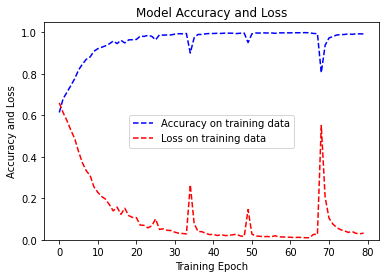

In [ ]:
plt.plot(longhistory_ovrsmpl.history['accuracy'], "b--", label="Accuracy on training data")
plt.plot(longhistory_ovrsmpl.history['loss'], "r--", label="Loss on training data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.savefig('80epochsOfFirstCNN_ovrsmpl')
plt.show()

In [ ]:
tot = len(molclass)
pos = sum(molclass.astype(int))
neg = tot - pos

w0 = (1. / neg) * tot / 2.
w1 = (1. / pos) * tot / 2.

cw = {'0': w0,
      '1': w1}

In [ ]:
modelcnn_wgtclss = basic_model()
longhistory_wgtclss = modelcnn_wgtclss.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=80, batch_size=256,
                    verbose=True,
                    class_weight=cw)

Train on 4911 samples, validate on 1228 samples
Epoch 1/80
4911/4911 [==============================] - 1s 212us/step - loss: 0.6818 - accuracy: 0.2824 - auc_2: 0.5666 - val_loss: 0.7493 - val_accuracy: 0.4243 - val_auc_2: 0.6359
Epoch 2/80
4911/4911 [==============================] - 1s 148us/step - loss: 0.6597 - accuracy: 0.5820 - auc_2: 0.6487 - val_loss: 0.7586 - val_accuracy: 0.4748 - val_auc_2: 0.6477
Epoch 3/80
4911/4911 [==============================] - 1s 152us/step - loss: 0.6385 - accuracy: 0.6608 - auc_2: 0.6572 - val_loss: 0.6900 - val_accuracy: 0.6034 - val_auc_2: 0.6638
Epoch 4/80
4911/4911 [==============================] - 1s 150us/step - loss: 0.6142 - accuracy: 0.6775 - auc_2: 0.6722 - val_loss: 0.6883 - val_accuracy: 0.6205 - val_auc_2: 0.6800
Epoch 5/80
4911/4911 [==============================] - 1s 150us/step - loss: 0.6080 - accuracy: 0.6921 - auc_2: 0.6863 - val_loss: 0.5526 - val_accuracy: 0.7476 - val_auc_2: 0.6909
Epoch 6/80
4911/4911 [====================

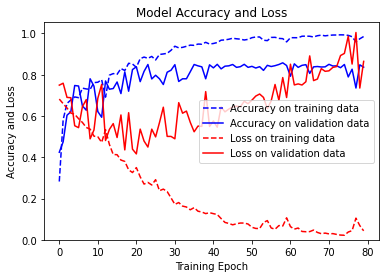

In [ ]:
# summarize history for accuracy and loss
#plt.figure(figsize=(6, 4))
plt.plot(longhistory_wgtclss.history['accuracy'], "b--", label="Accuracy on training data")
plt.plot(longhistory_wgtclss.history['val_accuracy'], "b", label="Accuracy on validation data")
plt.plot(longhistory_wgtclss.history['loss'], "r--", label="Loss on training data")
plt.plot(longhistory_wgtclss.history['val_loss'], "r", label="Loss on validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.savefig('80epochsOfFirstCNN_wgtclss')
plt.show()

In [ ]:
# Rebuild from scratch, given problems in api handling
# modelcnn = basic_model() actually built before and unmodified

history = modelcnn.fit(M_tensor, molclass,
                    epochs=16, batch_size=256,
                    verbose=True,
                    class_weight=cw)

Epoch 1/16
6139/6139 [==============================] - 1s 180us/step - loss: 0.6804 - accuracy: 0.3597 - auc: 0.5960
Epoch 2/16
6139/6139 [==============================] - 1s 131us/step - loss: 0.6569 - accuracy: 0.5840 - auc: 0.6348
Epoch 3/16
6139/6139 [==============================] - 1s 135us/step - loss: 0.6269 - accuracy: 0.6846 - auc: 0.6560
Epoch 4/16
6139/6139 [==============================] - 1s 129us/step - loss: 0.6000 - accuracy: 0.6973 - auc: 0.6790
Epoch 5/16
6139/6139 [==============================] - 1s 129us/step - loss: 0.5767 - accuracy: 0.7205 - auc: 0.6968
Epoch 6/16
6139/6139 [==============================] - 1s 130us/step - loss: 0.5554 - accuracy: 0.7301 - auc: 0.7167
Epoch 7/16
6139/6139 [==============================] - 1s 128us/step - loss: 0.5247 - accuracy: 0.7500 - auc: 0.7328
Epoch 8/16
6139/6139 [==============================] - 1s 130us/step - loss: 0.5061 - accuracy: 0.7487 - auc: 0.7477
Epoch 9/16
6139/6139 [==============================] - 

In [ ]:
# TRAIN SET FITTING STATS: MODELCNN WITH WEIGHTED CLASSES
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

Y_valid_predict = modelcnn.predict(M_tensor)
y_true = molclass.astype(int)
y_pred = []
for prediction in Y_valid_predict:
    prediction = np.where(prediction>0.5, 1, 0)
    y_pred.append(prediction)
y_pred = np.asarray(y_pred)
print('TRAIN SET FITTING STATS: MODELCNN WITH WEIGHTED CLASSES \n')
print(classification_report(y_true, y_pred))
print('roc-auc %f' % metrics.roc_auc_score(y_true, y_pred))

TRAIN SET FITTING STATS: MODELCNN WITH WEIGHTED CLASSES 

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      5174
           1       0.61      0.95      0.75       965

    accuracy                           0.90      6139
   macro avg       0.80      0.92      0.84      6139
weighted avg       0.93      0.90      0.91      6139

roc-auc 0.920213


In [ ]:
# TEST (SCORE) SET FITTING STATS: MODELCNN WITH WEIGHTED CLASSES
path = '/content/drive/My Drive/SMILES/SR-ARE_score_x.txt'
with open(path) as f:
    testdata = json.load(f)

path = path = '/content/drive/My Drive/SMILES/SR-ARE_score_y.txt'
with open(path) as f:
    testclass = json.load(f)

test_list = []
for mol in testdata:
  mol_matrix = np.reshape(mol, (400, 42))
  test_list.append(mol_matrix)
Test_tensor = np.array(test_list)

testclass = np.array(testclass)

Y_test_predict = modelcnn.predict(Test_tensor)
y_true = testclass.astype(int)
y_pred = []
for prediction in Y_test_predict:
    prediction = np.where(prediction>0.5, 1, 0)
    y_pred.append(prediction)
y_pred = np.asarray(y_pred)
print('TEST (SCORE) SET FITTING STATS: MODELCNN WITH WEIGHTED CLASSES \n')
print(classification_report(y_true, y_pred))
print('roc-auc %f' % metrics.roc_auc_score(y_true, y_pred))

TEST (SCORE) SET FITTING STATS: MODELCNN WITH WEIGHTED CLASSES 

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       461
           1       0.39      0.61      0.47        92

    accuracy                           0.78       553
   macro avg       0.65      0.71      0.67       553
weighted avg       0.82      0.78      0.79       553

roc-auc 0.708903


In [ ]:
# TRAIN SET FITTING STATS: MODELCNN WITH OVERSAMPLED TARGET CLASS
modelcnn_ovrsmpl = basic_model()
history_ovrsmpl = modelcnn_ovrsmpl.fit(X_resampled, y_resampled,
                    epochs=16, batch_size=256,
                    verbose=False)

Y_valid_predict = modelcnn_ovrsmpl.predict(X_resampled)
y_true = y_resampled.astype(int)
y_pred = []
for prediction in Y_valid_predict:
    prediction = np.where(prediction>0.5, 1, 0)
    y_pred.append(prediction)
y_pred = np.asarray(y_pred)
print('TRAIN SET FITTING STATS: MODELCNN WITH OVERSAMPLED TARGET CLASS \n')
print(classification_report(y_true, y_pred))
print('roc-auc %f' % metrics.roc_auc_score(y_true, y_pred))

TRAIN SET FITTING STATS: MODELCNN WITH OVERSAMPLED TARGET CLASS 

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      5174
           1       0.95      0.99      0.97      5174

    accuracy                           0.97     10348
   macro avg       0.97      0.97      0.97     10348
weighted avg       0.97      0.97      0.97     10348

roc-auc 0.969946


In [ ]:
# TEST (SCORE) SET FITTING STATS: MODELCNN WITH OVERSAMPLED TARGET CLASS
Y_test_predict = modelcnn_ovrsmpl.predict(Test_tensor)
y_true = testclass.astype(int)
y_pred = []
for prediction in Y_test_predict:
    prediction = np.where(prediction>0.5, 1, 0)
    y_pred.append(prediction)
y_pred = np.asarray(y_pred)
print('TEST (SCORE) SET FITTING STATS: MODELCNN WITH OVERSAMPLED TARGET CLASS \n')
print(classification_report(y_true, y_pred))
print('roc-auc %f' % metrics.roc_auc_score(y_true, y_pred))

TEST (SCORE) SET FITTING STATS: MODELCNN WITH OVERSAMPLED TARGET CLASS 

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       461
           1       0.38      0.53      0.45        92

    accuracy                           0.78       553
   macro avg       0.64      0.68      0.65       553
weighted avg       0.81      0.78      0.79       553

roc-auc 0.680621


Possiamo procedere con i pesi invece che con l'oversampling. Questo permette di usare la (cross)validation senza temere che il validation contenga elementi-copia, e riducendo il numero di sample da valutare.

In [ ]:
# CROSS VALIDATION FOR THIS MODEL
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seedval)
cv_accuracy = []
cv_rocauc = []
for train, test in kfold.split(M_tensor, molclass):
  # redefine Model 
  modelcnn = Sequential()
  modelcnn.add(Conv1D(filters=120, kernel_size=15, activation='relu', input_shape=(400, 42), padding='same'))
  modelcnn.add(MaxPooling1D(3))
  modelcnn.add(Conv1D(filters=120, kernel_size=15, activation='relu', padding='same'))
  modelcnn.add(MaxPooling1D(3))
  modelcnn.add(GlobalAveragePooling1D())
  modelcnn.add(Dropout(0.5))
  modelcnn.add(Dense(64, activation='relu'))
  modelcnn.add(Dense(1, activation='sigmoid'))
  modelcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()]) 
  # Fit the model 
  modelcnn.fit(M_tensor[train], molclass[train], epochs=26, batch_size=256, verbose=False, class_weight=cw) 
  # evaluate the model 
  scores = modelcnn.evaluate(M_tensor[test], molclass[test], verbose=False) 
  acc, auc = scores[1], scores[2] 
  cv_accuracy.append(acc) 
  cv_rocauc.append(auc)
  print('One fold made')
  
modelcnnmeanacc = np.mean(cv_accuracy)
modelcnnmeanrocaud = np.mean(cv_rocauc)
modelcnnstdacc = np.std(cv_accuracy)
modelcnnstdrocaud = np.std(cv_rocauc)
print("Accuracy CV estimate %.2f +/- %.2f" % (modelcnnmeanacc, modelcnnstdacc))
print("AUC CV estimate %.2f +/- %.2f" % (modelcnnmeanrocaud, modelcnnstdrocaud))


One fold made
One fold made
One fold made
One fold made
One fold made
Accuracy CV estimate 0.81 +/- 0.03
AUC CV estimate 0.87 +/- 0.01


In [ ]:
# CROSS V DEEPER
cv_accuracy = []
cv_rocauc = []

def deep_model():
  modeldeepcnn = Sequential() 
  modeldeepcnn.add(Conv1D(filters=120, kernel_size=15, activation='relu', input_shape=(400, 42), padding='same')) 
  modeldeepcnn.add(MaxPooling1D(3)) 
  modeldeepcnn.add(Conv1D(filters=120, kernel_size=15, activation='relu', padding='same')) 
  modeldeepcnn.add(MaxPooling1D(3)) 
  modeldeepcnn.add(Conv1D(filters=120, kernel_size=15, activation='relu', padding='same')) 
  modeldeepcnn.add(GlobalAveragePooling1D()) 
  modeldeepcnn.add(Dropout(0.5)) 
  modeldeepcnn.add(Dense(64, activation='relu')) 
  modeldeepcnn.add(Dense(1, activation='sigmoid')) 
  modeldeepcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()]) 
  return modeldeepcnn

for train, test in kfold.split(M_tensor, molclass):
  # redefine Model 
  modeldeepcnn = deep_model()
  # Fit the model 
  modeldeepcnn.fit(M_tensor[train], molclass[train], epochs=26, batch_size=256, verbose=False, class_weight=cw) 
  # evaluate the model 
  scores = modeldeepcnn.evaluate(M_tensor[test], molclass[test], verbose=False) 
  acc, auc = scores[1], scores[2] 
  cv_accuracy.append(acc) 
  cv_rocauc.append(auc)
  print('One fold made')
  
modeldeepcnnmeanacc = np.mean(cv_accuracy)
modeldeepcnnmeanrocaud = np.mean(cv_rocauc)
modeldeepcnnstdacc = np.std(cv_accuracy)
modeldeepcnnstdrocaud = np.std(cv_rocauc)
print("Accuracy CV estimate %.2f +/- %.2f" % (modeldeepcnnmeanacc, modeldeepcnnstdacc))
print("AUC CV estimate %.2f +/- %.2f" % (modeldeepcnnmeanrocaud, modeldeepcnnstdrocaud))

One fold made
One fold made
One fold made
One fold made
One fold made
Accuracy CV estimate 0.84 +/- 0.02
AUC CV estimate 0.93 +/- 0.01


In [ ]:
# CROSS MANY FILTERS BIG KERNEL
cv_accuracy = []
cv_rocauc = []

def wide_model_bigk():
  modelmanywidecnn = Sequential() 
  modelmanywidecnn.add(Conv1D(filters=300, kernel_size=30, activation='relu', input_shape=(400, 42), padding='same')) 
  modelmanywidecnn.add(MaxPooling1D(3)) 
  modelmanywidecnn.add(Conv1D(filters=300, kernel_size=30, activation='relu', padding='same')) 
  modelmanywidecnn.add(GlobalAveragePooling1D()) 
  modelmanywidecnn.add(Dropout(0.5)) 
  modelmanywidecnn.add(Dense(64, activation='relu')) 
  modelmanywidecnn.add(Dense(1, activation='sigmoid')) 
  modelmanywidecnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
  return modelmanywidecnn

for train, test in kfold.split(M_tensor, molclass):
  # redefine Model 
  modelmanywidecnn = wide_model_bigk() 
  # Fit the model 
  modelmanywidecnn.fit(M_tensor[train], molclass[train], epochs=26, batch_size=256, verbose=False, class_weight=cw) 
  # evaluate the model 
  scores = modelmanywidecnn.evaluate(M_tensor[test], molclass[test], verbose=False) 
  acc, auc = scores[1], scores[2] 
  cv_accuracy.append(acc) 
  cv_rocauc.append(auc)
  print('One fold made')
  
modelmanywidecnnmeanacc = np.mean(cv_accuracy)
modelmanywidecnnmeanrocaud = np.mean(cv_rocauc)
modelmanywidecnnstdacc = np.std(cv_accuracy)
modelmanywidecnnstdrocaud = np.std(cv_rocauc)
print("Accuracy CV estimate %.2f +/- %.2f" % (modelmanywidecnnmeanacc, modelmanywidecnnstdacc))
print("AUC CV estimate %.2f +/- %.2f" % (modelmanywidecnnmeanrocaud, modelmanywidecnnstdrocaud))

One fold made
One fold made
One fold made
One fold made
One fold made
Accuracy CV estimate 0.84 +/- 0.02
AUC CV estimate 0.95 +/- 0.00


In [ ]:
# CROSS MANY FILTERS SMALL KERNEL
cv_accuracy = []
cv_rocauc = []

def wide_model_smallk():
  modelmanynarcnn = Sequential() 
  modelmanynarcnn.add(Conv1D(filters=300, kernel_size=8, activation='relu', input_shape=(400, 42), padding='same')) 
  modelmanynarcnn.add(MaxPooling1D(3)) 
  modelmanynarcnn.add(Conv1D(filters=300, kernel_size=8, activation='relu', padding='same')) 
  modelmanynarcnn.add(GlobalAveragePooling1D()) 
  modelmanynarcnn.add(Dropout(0.5)) 
  modelmanynarcnn.add(Dense(64, activation='relu')) 
  #modelcnn.add(Dropout(0.5)) 
  modelmanynarcnn.add(Dense(1, activation='sigmoid')) 
  modelmanynarcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
  return modelmanynarcnn

for train, test in kfold.split(M_tensor, molclass):
  # redefine Model 
  modelmanynarcnn = wide_model_smallk()
  # Fit the model 
  modelmanynarcnn.fit(M_tensor[train], molclass[train], epochs=26, batch_size=256, verbose=False, class_weight=cw) 
  # evaluate the model 
  scores = modelmanynarcnn.evaluate(M_tensor[test], molclass[test], verbose=False) 
  acc, auc = scores[1], scores[2] 
  cv_accuracy.append(acc) 
  cv_rocauc.append(auc)
  print('One fold made')
  
modelmanynarcnnmeanacc = np.mean(cv_accuracy)
modelmanynarcnnmeanrocaud = np.mean(cv_rocauc)
modelmanynarcnnstdacc = np.std(cv_accuracy)
modelmanynarcnnstdrocaud = np.std(cv_rocauc)
print("Accuracy CV estimate %.2f +/- %.2f" % (modelmanynarcnnmeanacc, modelmanynarcnnstdacc))
print("AUC CV estimate %.2f +/- %.2f" % (modelmanynarcnnmeanrocaud, modelmanynarcnnstdrocaud))

One fold made
One fold made
One fold made
One fold made
One fold made
Accuracy CV estimate 0.78 +/- 0.05
AUC CV estimate 0.85 +/- 0.01


In [ ]:
# DEEPER ON SCORE
# DEEPCNN ON WHOLETRAIN, FIRST WITH A VALID SPLIT TO CHECK FOR OVERFITTING
# THEN RETRAINED ON WHOLE DATA TO CHECK ON THE SCORE DATASET
modeldeepcnn = deep_model() 
# Fit the model
longhistory_deepcnn = modeldeepcnn.fit(M_tensor, molclass,
                    epochs=40, batch_size=256,
                    verbose=True,
                    validation_split=0.2,
                    class_weight=cw)

Train on 4911 samples, validate on 1228 samples
Epoch 1/40
4911/4911 [==============================] - 1s 249us/step - loss: 0.6488 - accuracy: 0.6241 - auc_24: 0.5763 - val_loss: 0.7544 - val_accuracy: 0.4976 - val_auc_24: 0.6357
Epoch 2/40
4911/4911 [==============================] - 1s 190us/step - loss: 0.6244 - accuracy: 0.6736 - auc_24: 0.6535 - val_loss: 0.7715 - val_accuracy: 0.6621 - val_auc_24: 0.6562
Epoch 3/40
4911/4911 [==============================] - 1s 192us/step - loss: 0.5990 - accuracy: 0.6695 - auc_24: 0.6676 - val_loss: 0.8090 - val_accuracy: 0.7533 - val_auc_24: 0.6687
Epoch 4/40
4911/4911 [==============================] - 1s 190us/step - loss: 0.5825 - accuracy: 0.7086 - auc_24: 0.6736 - val_loss: 0.7757 - val_accuracy: 0.7125 - val_auc_24: 0.6801
Epoch 5/40
4911/4911 [==============================] - 1s 187us/step - loss: 0.5633 - accuracy: 0.6913 - auc_24: 0.6874 - val_loss: 0.7329 - val_accuracy: 0.6425 - val_auc_24: 0.6946
Epoch 6/40
4911/4911 [==========

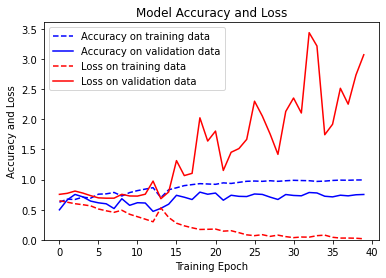

In [ ]:
plt.plot(longhistory_deepcnn.history['accuracy'], "b--", label="Accuracy on training data")
plt.plot(longhistory_deepcnn.history['val_accuracy'], "b", label="Accuracy on validation data")
plt.plot(longhistory_deepcnn.history['loss'], "r--", label="Loss on training data")
plt.plot(longhistory_deepcnn.history['val_loss'], "r", label="Loss on validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.savefig('40epochsOfdeepCNN')
plt.show()

In [ ]:
# TRAIN ON WHOLE AND RATE ON SCORE
# MAKE STATS FOR 10 TRIALS, save pr re f1 score avgacc rocauc

pr_hat=[]
re_hat=[]
f1_hat=[]
avgacc_hat=[]
rocauc_hat=[]
for i in range(10):
  modeldeepcnn = deep_model() 
  # Fit the model
  history_deepcnn = modeldeepcnn.fit(M_tensor, molclass,
                      epochs=15, batch_size=256,
                      verbose=False,
                      class_weight=cw)

  Y_test_predict = modeldeepcnn.predict(Test_tensor)
  y_true = testclass.astype(int)
  y_pred = []
  for prediction in Y_test_predict:
      prediction = np.where(prediction>0.5, 1, 0)
      y_pred.append(prediction)
  y_pred = np.asarray(y_pred)
  rep=classification_report(y_true, y_pred, output_dict=True)
  pr, re, f1, avgacc, rocauc = rep['1']['precision'],rep['1']['recall'],rep['1']['f1-score'],rep['accuracy'], metrics.roc_auc_score(y_true, y_pred)
  pr_hat.append(pr)
  re_hat.append(re)
  f1_hat.append(f1)
  avgacc_hat.append(avgacc)
  rocauc_hat.append(rocauc)
  print('One run complete')

pr_sd=np.std(pr_hat)
re_sd=np.std(re_hat)
f1_sd=np.std(f1_hat)
avgacc_sd=np.std(avgacc_hat)
rocauc_sd=np.std(rocauc_hat)

pr_hat=np.mean(pr_hat)
re_hat=np.mean(re_hat)
f1_hat=np.mean(f1_hat)
avgacc_hat=np.mean(avgacc_hat)
rocauc_hat=np.mean(rocauc_hat)

print('TEST (SCORE) STATISTICS FOR DEEP CNN MODEL')
print('precision: %.2f +/- %.2f' % (pr_hat, pr_sd))
print('recall: %.2f +/- %.2f' % (re_hat, re_sd))
print('f1-score: %.2f +/- %.2f' % (f1_hat, f1_sd))
print('accuracy: %.2f +/- %.2f' % (avgacc_hat, avgacc_sd))
print('roc-auc: %.2f +/- %.2f' % (rocauc_hat, rocauc_sd))


One run complete
One run complete
One run complete
One run complete
One run complete
One run complete
One run complete
One run complete
One run complete
One run complete
TEST (SCORE) STATISTICS FOR DEEP CNN MODEL
precision: 0.40 +/- 0.04
recall: 0.54 +/- 0.09
f1-score: 0.46 +/- 0.03
accuracy: 0.79 +/- 0.03
roc-auc: 0.69 +/- 0.03


In [ ]:
# WIDER ON SCORE
# WIDECNN ON WHOLETRAIN, FIRST WITH A VALID SPLIT TO CHECK FOR OVERFITTING
# THEN RETRAINED ON WHOLE DATA TO CHECK ON THE SCORE DATASET
modelmanywidecnn = wide_model_bigk() 
# Fit the model
longhistory_widecnn = modelmanywidecnn.fit(M_tensor, molclass,
                    epochs=40, batch_size=256,
                    verbose=True,
                    validation_split=0.2,
                    class_weight=cw)

Train on 4911 samples, validate on 1228 samples
Epoch 1/40
4911/4911 [==============================] - 3s 522us/step - loss: 0.6630 - accuracy: 0.3667 - auc_36: 0.5783 - val_loss: 0.7646 - val_accuracy: 0.3941 - val_auc_36: 0.6028
Epoch 2/40
4911/4911 [==============================] - 2s 447us/step - loss: 0.6415 - accuracy: 0.5638 - auc_36: 0.6323 - val_loss: 0.7991 - val_accuracy: 0.7508 - val_auc_36: 0.6277
Epoch 3/40
4911/4911 [==============================] - 2s 448us/step - loss: 0.6113 - accuracy: 0.7218 - auc_36: 0.6312 - val_loss: 0.7349 - val_accuracy: 0.6205 - val_auc_36: 0.6458
Epoch 4/40
4911/4911 [==============================] - 2s 450us/step - loss: 0.5759 - accuracy: 0.7296 - auc_36: 0.6613 - val_loss: 0.7444 - val_accuracy: 0.6857 - val_auc_36: 0.6699
Epoch 5/40
4911/4911 [==============================] - 2s 447us/step - loss: 0.5453 - accuracy: 0.7390 - auc_36: 0.6818 - val_loss: 0.7915 - val_accuracy: 0.7402 - val_auc_36: 0.6882
Epoch 6/40
4911/4911 [==========

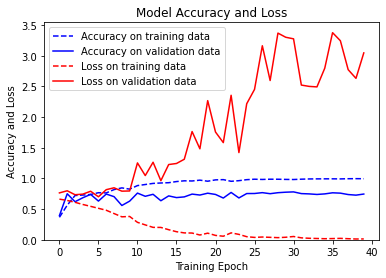

In [ ]:
plt.plot(longhistory_widecnn.history['accuracy'], "b--", label="Accuracy on training data")
plt.plot(longhistory_widecnn.history['val_accuracy'], "b", label="Accuracy on validation data")
plt.plot(longhistory_widecnn.history['loss'], "r--", label="Loss on training data")
plt.plot(longhistory_widecnn.history['val_loss'], "r", label="Loss on validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.savefig('40epochsOfwideCNN')
plt.show()

In [ ]:
# WIDER ON SCORE
# WIDECNN ON WHOLETRAIN, FIRST WITH A VALID SPLIT TO CHECK FOR OVERFITTING
# THEN RETRAINED ON WHOLE DATA TO CHECK ON THE SCORE DATASET

pr_hat=[]
re_hat=[]
f1_hat=[]
avgacc_hat=[]
rocauc_hat=[]
for i in range(10):
  modelmanywidecnn = wide_model_bigk() 
  # Fit the model
  history_widecnn = modelmanywidecnn.fit(M_tensor, molclass,
                      epochs=10, batch_size=256,
                      verbose=False,
                      class_weight=cw)

  Y_test_predict = modelmanywidecnn.predict(Test_tensor)
  y_true = testclass.astype(int)
  y_pred = []
  for prediction in Y_test_predict:
      prediction = np.where(prediction>0.5, 1, 0)
      y_pred.append(prediction)
  y_pred = np.asarray(y_pred)
  rep=classification_report(y_true, y_pred, output_dict=True)
  pr, re, f1, avgacc, rocauc = rep['1']['precision'],rep['1']['recall'],rep['1']['f1-score'],rep['accuracy'], metrics.roc_auc_score(y_true, y_pred)
  pr_hat.append(pr)
  re_hat.append(re)
  f1_hat.append(f1)
  avgacc_hat.append(avgacc)
  rocauc_hat.append(rocauc)
  print('One run complete')

pr_sd=np.std(pr_hat)
re_sd=np.std(re_hat)
f1_sd=np.std(f1_hat)
avgacc_sd=np.std(avgacc_hat)
rocauc_sd=np.std(rocauc_hat)

pr_hat=np.mean(pr_hat)
re_hat=np.mean(re_hat)
f1_hat=np.mean(f1_hat)
avgacc_hat=np.mean(avgacc_hat)
rocauc_hat=np.mean(rocauc_hat)

print('TEST (SCORE) STATISTICS FOR DEEP CNN MODEL')
print('precision: %.2f +/- %.2f' % (pr_hat, pr_sd))
print('recall: %.2f +/- %.2f' % (re_hat, re_sd))
print('f1-score: %.2f +/- %.2f' % (f1_hat, f1_sd))
print('accuracy: %.2f +/- %.2f' % (avgacc_hat, avgacc_sd))
print('roc-auc: %.2f +/- %.2f' % (rocauc_hat, rocauc_sd))

One run complete
One run complete
One run complete
One run complete
One run complete
One run complete
One run complete
One run complete
One run complete
One run complete
TEST (SCORE) STATISTICS FOR DEEP CNN MODEL
precision: 0.35 +/- 0.03
recall: 0.62 +/- 0.10
f1-score: 0.44 +/- 0.02
accuracy: 0.74 +/- 0.05
roc-auc: 0.69 +/- 0.02
